In [1]:
from constraints import *
from helper import *

In [2]:
def forwardEulerDC(init,constants,plot=False, control_bounds=(-0.1,0.1)):
    x0, y0, theta0 = init[0], init[1], init[2]
    
    T = constants["T"]
    del_t = constants["del_t"]
    V = constants["V"]
    xs, ys, thetas = [x0], [y0], [theta0]
    x,y,theta = x0, y0, theta0
    for t in range(T):
        u_t = np.random.uniform(control_bounds[0],control_bounds[1])
        x, y, theta = V*np.cos(theta)*del_t + x, V*np.sin(theta)*del_t + y, u_t*del_t + theta
        xs.append(x)
        ys.append(y)
        thetas.append(theta)
        
    traj = [(xs[i],ys[i],thetas[i]) for i in range(len(xs))]
    return traj

def forwardEulerDC_control(init,constants,plot=False):
    x0, y0, theta0 = init[0], init[1], init[2]
    
    T = constants["T"]
    del_t = constants["del_t"]
    V = constants["V"]
    xs, ys, thetas,us = [], [], [], []
    x,y,theta = x0, y0, theta0
    for t in range(T):
        u_t = np.random.uniform(-1,1)
        us.append(u_t)
        xs.append(x)
        ys.append(y)
        thetas.append(theta)
        x, y, theta = V*np.cos(theta)*del_t + x, V*np.sin(theta)*del_t + y, u_t*del_t + theta
        
    traj = [(xs[i],ys[i],thetas[i],us[i]) for i in range(len(xs))]
    return traj

In [3]:
# horizon and forward Euler time step
T = 10
del_t = 0.1

# box constraints for initial state
x0 = 1
y0 = 1
theta0 = 1
x_dev = 0.01
y_dev = 0.01
theta_dev = 0.01

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0
theta_up_b = theta_dev + theta0
theta_lw_b = -1*theta_dev + theta0

V = 1

# constants for dynamics
constants = {"T":T, "del_t":del_t,
             "x0":x0, "y0":y0, "theta0":theta0, "V":V}

delt = 0.5
control_bounds = [np.pi-delt,np.pi+delt]

x_range, y_range, theta_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev], [theta0 - theta_dev, theta0 + theta_dev]

Number Valid: 2999995
Time:  3
(1.0715146476675401, 1.2923776795850008, 2.0094644559161012)
([0.9627233031281832, 1.1960581153381633], [1.2684937251524548, 1.2921374918026713], [1.782477796076938, 2.102477796076938])
1

False


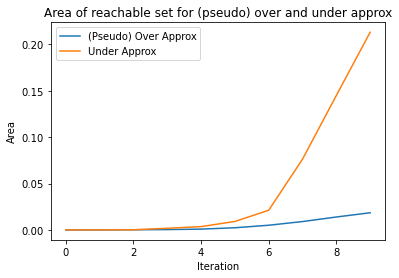

In [4]:
areas_fast = []
times_fast = []
boxes_fast = []

x0_bounds = BoxConstraints(x_lw_b,x_up_b)
y0_bounds = BoxConstraints(y_lw_b,y_up_b)
theta0_bounds = BoxConstraints(theta_lw_b,theta_up_b)
u0_bounds = BoxConstraints(control_bounds[0],control_bounds[1])

var_bounds = {"x":x0_bounds, "y":y0_bounds, "theta":theta0_bounds, "u":u0_bounds}

x_0_coeffs = {"x":1, "y":0, "theta":0, "u":0, "_const":0}
x_0 = LinearConstraints(Line(x_0_coeffs.copy()), Line(x_0_coeffs.copy()),var_bounds)

y_0_coeffs = {"x":0, "y":1, "theta":0, "u":0, "_const":0}
y_0 = LinearConstraints(Line(y_0_coeffs.copy()), Line(y_0_coeffs.copy()),var_bounds)

theta_0_coeffs = {"x":0, "y":0, "theta":1, "u":0, "_const":0}
theta_0 = LinearConstraints(Line(theta_0_coeffs.copy()), Line(theta_0_coeffs.copy()),var_bounds)

u_0_coeffs = {"x":0, "y":0, "theta":0, "u":1, "_const":0}
u_0 = LinearConstraints(Line(u_0_coeffs.copy()), Line(u_0_coeffs.copy()),var_bounds)

for t in range(constants["T"]):
    tt = time.time()
    V = constants["V"]
    box_x, box_y, box_theta = x_0.eval_box(), y_0.eval_box(), theta_0.eval_box()
    areas_fast.append((box_x.upper-box_x.lower)*(box_y.upper-box_y.lower))
    b = ([box_x.lower,box_x.upper],[box_y.lower,box_y.upper],[box_theta.lower,box_theta.upper])
    boxes_fast.append(b)
    
    x_temp = theta_0.cos(adaptive=True).mult_const(constants["del_t"]*V).add(x_0)
    y_temp = theta_0.sin(adaptive=True).mult_const(constants["del_t"]*V).add(y_0)
    theta_temp = u_0.mult_const(constants["del_t"]).add(theta_0)
    x_0, y_0, theta_0 = x_temp, y_temp, theta_temp
    
    tt = time.time() - tt
    times_fast.append(tt)

fe = lambda init,constants,plot: forwardEulerDC(init,constants,plot,control_bounds=(control_bounds[0],control_bounds[1]))
# print(np.pi/2, np.pi, np.pi*1.5)
print(verify_valid_boxes(boxes_fast,[x_range,y_range,theta_range],n=100000,forwardEuler=fe,constants=constants,debug=True))



In [4]:
def DubinsConstraints(T=1,variables=[],constraints=[],control_bounds=[],Npast=0, use_convex=False, constants={}, debug=False):
    times = []
    ss = []
    boxes = []
    del_t = constants["del_t"]
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)
        theta = variables[t]["theta"]
        theta_bounds = bounds(theta,constraints,Npast=Npast)
        xL,xU = x_bounds
        yL,yU = y_bounds
        thetaL,thetaU = theta_bounds
        b = ([xL,xU],[yL,yU],[thetaL,thetaU])
        boxes.append(b)
        if t == 1 and debug: print(b)
        ss.append((xU-xL)*(yU-yL))
        
        # del_t*u
        u = variables[t]["u"]
        constraints.append(u <= control_bounds[0][1]*del_t)
        constraints.append(u >= control_bounds[0][0]*del_t)
        
        # cos
        c1 = variables[t]["c1"]
        constraints.extend(cos_adaptive_cvx(c1,theta,theta_bounds,debug=(t==0 and debug)))
        
        # V*del_t*cosine
        c = variables[t]["c"]
        constraints.append(c == constants["V"]*del_t*c1)
        
        # sin
        s1 = variables[t]["s1"]
        constraints.extend(sin_adaptive_cvx(s1,theta,theta_bounds,debug=(t==0 and debug)))
        
        # V*del_t*sine
        s = variables[t]["s"]
        constraints.append(s == constants["V"]*del_t*s1)
        
        x_new = variables[t+1]["x"]
        constraints.append(x_new == c + x)
        
        y_new = variables[t+1]["y"]
        constraints.append(y_new == s + y)
        
        theta_new = variables[t+1]["theta"]
        constraints.append(theta_new == u + theta)

        tt = time.time() - tt
        times.append(tt)

    
    return variables,constraints, times, ss, boxes

cos(x) lower:  {'_const': 1.3817322513402446, 'x_cos': -0.8414569603618323}
cos(x) upper:  {'_const': 1.3817732906760352, 'x_cos': -0.8414709848078954}
sin(x) lower:  {'_const': 0.3011356107350698, 'x_sin': 0.5402933008748848}
sin(x) upper:  {'_const': 0.3011686789397551, 'x_sin': 0.5403023058681414}
([1.0431860721595478, 1.0648717015492986], [1.0736025978911343, 1.094687400755581], [1.2541592659735075, 1.374159264746803])
10000
Number Valid: 300000 True True
True


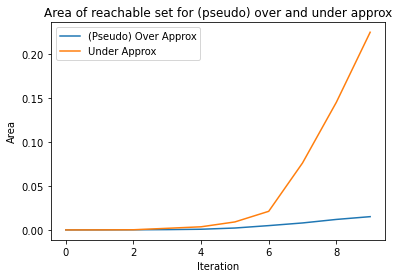

In [5]:
variables = [{"u":cvxpy.Variable(),"c1":cvxpy.Variable(),"s1":cvxpy.Variable(),"c":cvxpy.Variable(),"s":cvxpy.Variable(),"x":cvxpy.Variable(),"y":cvxpy.Variable(),"theta":cvxpy.Variable()} for t in range(T+1)]

# plt.figure(2)
# plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')

x = variables[0]["x"]
y = variables[0]["y"]
theta = variables[0]["theta"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)
constraints.append(theta >= theta_lw_b)
constraints.append(theta <= theta_up_b)

control_bounds_cvx = [(control_bounds[0], control_bounds[1]) for t in range(T)]

variables_convex,constraints_convex,times_convex,areas_convex,boxes_convex = DubinsConstraints(T,variables,constraints,control_bounds_cvx,use_convex=False,constants=constants,debug=True)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)
thetaL,thetaU = bounds(variables[-1]["theta"],constraints)
fe = lambda init,constants,plot: forwardEulerDC(init,constants,plot,control_bounds=(control_bounds[0],control_bounds[1]))
print(verify_valid_boxes(boxes_convex,[x_range,y_range,theta_range],n=10000,forwardEuler=fe,constants=constants,debug=True))
